<h1 align='center'>MINI-TRANSFORMER</h1>
<h2 align='center'>Financial Sentiment Analysis</h2>

Here we are implemeting our previously develped Transformer Model from scratch availabe in `transformers_model.py` and using only `Encoder` layer and devloping our own ***Mini Transformer for Sentiment Analysis from scratch***. We are using a small Financial NEWS dataset available on HuggingFace `fiancial_phrasebank`.

## Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from datasets import DatasetDict
from transformers_model import Encoder, create_padding_mask

c:\Users\Utkarsh\miniconda3\envs\tf_legacy\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\Utkarsh\miniconda3\envs\tf_legacy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Dataset

In [2]:
raw_dataset = load_dataset('financial_phrasebank', 'sentences_allagree', trust_remote_code=True)

In [3]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

In [4]:
train_test_split = raw_dataset['train'].train_test_split(test_size=0.2, seed=42)

In [5]:
split_datasets = DatasetDict({
    'train': train_test_split['train'],
    'validation': train_test_split['test']
})

split_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1811
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 453
    })
})

## Preprocessing Data

### Building a vocabulary

In [6]:
vocab = {'<PAD>': 0, '<UNK>': 1}
for sentence in split_datasets['train']['sentence']:
    for word in sentence.lower().split():
        if word not in vocab:
            vocab[word] = len(vocab)

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 6209


### Tokenize and numericalize

In [7]:
def tokenize_and_numericalize(example):
    tokens = example['sentence'].lower().split()
    input_ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    return {'input_ids': input_ids}

In [8]:
tokenized_dataset = split_datasets.map(tokenize_and_numericalize, remove_columns=['sentence'])

In [9]:
tokenized_dataset = tokenized_dataset.rename_column('label', 'labels')

In [10]:
tokenized_dataset.set_format(type='python', columns=['input_ids', 'labels'])

In [11]:
print('Tokenized Dataset structure: ')
print(tokenized_dataset)

Tokenized Dataset structure: 
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids'],
        num_rows: 1811
    })
    validation: Dataset({
        features: ['labels', 'input_ids'],
        num_rows: 453
    })
})


In [12]:
print('Example of tokenized sample:')
print(tokenized_dataset['train'][0])

Example of tokenized sample:
{'labels': 1, 'input_ids': [2, 3, 4, 5, 6, 7, 8, 6, 7, 4, 9, 10, 11, 12, 13, 3, 14, 11, 15]}


### Padding `input_ids`

In [13]:
train_input_ids = [item['input_ids'] for item in tokenized_dataset['train']]
validation_input_ids = [item['input_ids'] for item in tokenized_dataset['validation']]

In [14]:
max_len = max(len(x) for x in train_input_ids)
print(f'Maximum sequence length: {max_len}')

Maximum sequence length: 81


In [15]:
# Pad the sequence
train_input_ids = tf.keras.preprocessing.sequence.pad_sequences(
    train_input_ids, maxlen=max_len, padding='post', truncating='post'
)
validation_input_ids = tf.keras.preprocessing.sequence.pad_sequences(
    validation_input_ids, maxlen=max_len, padding='post', truncating='post'
)

In [16]:
# labels
train_labels = np.array([item['labels'] for item in tokenized_dataset['train']])
validation_labels = np.array([item['labels'] for item in tokenized_dataset['validation']])

## Creating Tensorflow Dataset

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_ids, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_input_ids, validation_labels))

In [18]:
batch_size = 64
shuffle_buffer_size = 200

train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

print("Example of a padded training sample:")
for input_ids, labels in train_dataset.take(1):
    print("Input IDs:", input_ids[0])
    print("Label:", labels[0])

Example of a padded training sample:
Input IDs: tf.Tensor(
[  7 656   6  20 565 260 657 658  75 659 660 661 258 662 260  47 663 260
  12   9 664  75 135 665  28 666 470  12 667  72  15   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0], shape=(81,), dtype=int32)
Label: tf.Tensor(1, shape=(), dtype=int32)


This completes our Data Preprocessing Step and we are now ready to build our model for Sentiment Analysis and feed data into it for training.

## Adapting Model for Sentiment Analysis

We are going to use our previously develoed `Encoder` layer for the `SentimentAnalysis` model. Since it is a task of classification and such tasks uses only **Encoder Layer**. Models like ***BERT*** and ***RoBERTa*** uses same method only.

Also before using `Encoder`, we added the **l2 regularization** in its `FullyConnected` Layer, since we are using only Encoder Layer, this will help in reducing the ***overfitting*** of data.

In [19]:
class SentimentAnalysis(tf.keras.Model):
    """
    A Transformer-based model for sentiment analysis.
    
    This model uses the Encoder part of the Transformer architecture to generate
    a contextual representation of the input sentence. A dense layer is then
    used to classify the sentiment.
    """
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, num_classes=3, dropout_rate=0.1):
        super(SentimentAnalysis, self).__init__()

        # Encoder from the Model
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, maximum_position_encoding, dropout_rate)
        
        # Dense layer for classification
        self.final_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x, training, enc_padding_mask):
        """
        Forward pass for the sentiment analysis model.

        Args:
            x (tf.Tensor): Input tensor of shape (batch_size, input_seq_len)
            training (bool): Whether the model is in training mode
            enc_padding_mask (tf.Tensor): Mask for the encoder padding

        Returns:
            tf.Tensor: The output of the classification layer, a tensor of
                        shape (batch_size, num_classes)
        """
        # Get Encoder Output
        enc_output = self.encoder(x, training, enc_padding_mask)   # (batch_size, inp_seq_len, d_model)

        # Use the output for the 1st token, the [CLS] token
        cls_output = enc_output[:, 0, :]

        # Passing the output to final classification Layer
        final_output = self.final_layer(cls_output)   # (batch_size, num_classes)

        return final_output

### Initializing the Model

After defining the model, the next task is to initialize it with hyperparameters according to our data and requirements.

In [20]:
num_layers = 2
d_model = 128
num_heads = 8
dff = 512
input_vocab_size = 6209
maximum_position_encoding = 5000
num_classes = 3
dropout_rate = 0.1

In [21]:
model = SentimentAnalysis(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=input_vocab_size,
    maximum_position_encoding=maximum_position_encoding,
    num_classes=num_classes,
    dropout_rate=dropout_rate)

Here we are using `SparseCategoricalCrossentropy` loss function as we have three categories in the target labels, and since we are using logits for our predictions, we will keep `from_logits=True`.

We have also defined **learning rate schedule** for `Adam` optimizer.

In [22]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10_000,
    decay_rate=0.9,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

#### Training Loop

In [23]:
import time

In [24]:
@tf.function
def train_step(inp, tar, model, loss_object, optimizer):
    with tf.GradientTape() as tape:
        enc_padding_mask = create_padding_mask(inp)
        predictions = model(inp, True, enc_padding_mask)
        loss = loss_object(tar, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [25]:
@tf.function
def validation_step(inp, tar, model, loss_object):
    enc_padding_mask = create_padding_mask(inp)
    predictions = model(inp, False, enc_padding_mask)
    loss = loss_object(tar, predictions)
    return loss

In [26]:
def train_model(epochs, train_dataset, validation_dataset, model, loss_object, optimizer):
    train_loss_history = []
    validation_loss_history = []

    for epoch in range(epochs):
        start = time.time()

        train_loss = tf.keras.metrics.Mean(name='train_loss')
        validation_loss = tf.keras.metrics.Mean(name='validation_loss')

        # Training
        for (batch, (inp, tar)) in enumerate(train_dataset):
            loss = train_step(inp, tar, model, loss_object, optimizer)
            train_loss(loss)

        # Validation
        for (batch, (inp, tar)) in enumerate(validation_dataset):
            loss = validation_step(inp, tar, model, loss_object)
            validation_loss(loss)

        train_loss_history.append(train_loss.result())
        validation_loss_history.append(validation_loss.result())

        print(f"Epoch {epoch + 1}; Loss {train_loss.result():.4f}; Validation Loss {validation_loss.result():.4f}")
        print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\\n')

    return train_loss_history, validation_loss_history

## Training

In [27]:
epochs = 10

train_loss_history, validation_loss_history = train_model(
    epochs, train_dataset, validation_dataset, model, loss_object, optimizer
)

Epoch 1; Loss 0.9539; Validation Loss 0.8732
Time taken for 1 epoch: 36.80 secs\n
Epoch 2; Loss 0.8407; Validation Loss 0.7890
Time taken for 1 epoch: 31.92 secs\n
Epoch 3; Loss 0.7427; Validation Loss 0.7636
Time taken for 1 epoch: 31.81 secs\n
Epoch 4; Loss 0.6348; Validation Loss 0.6001
Time taken for 1 epoch: 32.77 secs\n
Epoch 5; Loss 0.4920; Validation Loss 0.5831
Time taken for 1 epoch: 32.78 secs\n
Epoch 6; Loss 0.4059; Validation Loss 0.6179
Time taken for 1 epoch: 32.13 secs\n
Epoch 7; Loss 0.3470; Validation Loss 0.6175
Time taken for 1 epoch: 32.16 secs\n
Epoch 8; Loss 0.2886; Validation Loss 0.6490
Time taken for 1 epoch: 31.34 secs\n
Epoch 9; Loss 0.2147; Validation Loss 0.6540
Time taken for 1 epoch: 31.18 secs\n
Epoch 10; Loss 0.1604; Validation Loss 0.6647
Time taken for 1 epoch: 33.00 secs\n


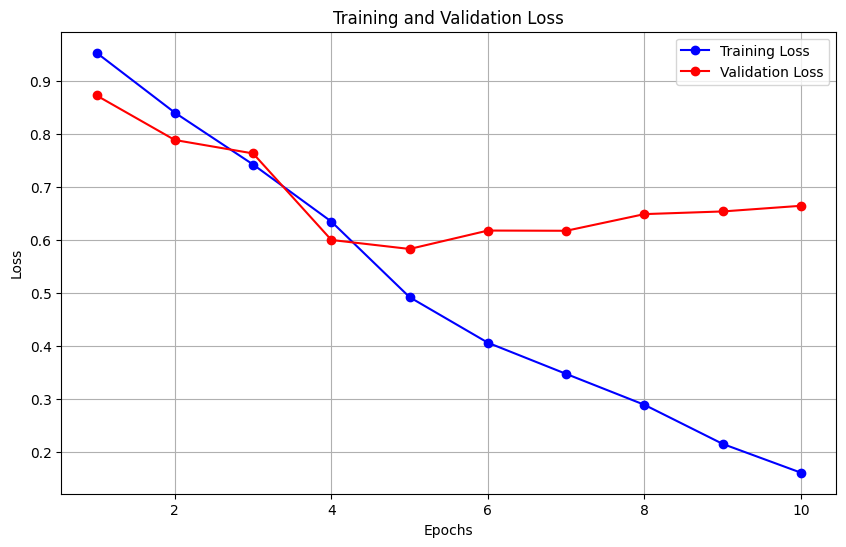

In [28]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, train_loss_history, 'b-o', label="Training Loss")
plt.plot(epochs, validation_loss_history, 'r-o', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

As we can see the training loss is falling gradually but the validation loss first falls, then starts moving randomly. This shows that the model is ***not generalizing well***. This may be beacuse of small dataset and with this little dataset, the model is not able to learn well. We need to use more data in the training process to address this issue.

### Checking the Model

In [29]:
def predict_sentiment(sentence, model, vocab, max_len):

    tokens = sentence.lower().split()
    input_ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]

    # Pad the sequence
    padding_input_ids = tf.keras.preprocessing.sequence.pad_sequences(
        [input_ids], maxlen=max_len, padding='post', truncating='post'
    )

    # Create tensor and padding mask
    input_tensor = tf.convert_to_tensor(padding_input_ids)
    enc_padding_mask = create_padding_mask(input_tensor)

    # Make prediction
    predictions = model(input_tensor, training=False, enc_padding_mask=enc_padding_mask)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Map the class to a sentiment label
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_sentiment = sentiment_labels[predicted_class]

    return predicted_sentiment

In [30]:
# Example 1: Positive Sentiment

sentence1 = "The company reported a significant increase in profits."
prediction1 = predict_sentiment(sentence1, model, vocab, max_len)
print(f"Sentence: '{sentence1}'")
print(f"Predicted Sentiment: {prediction1}")

Sentence: 'The company reported a significant increase in profits.'
Predicted Sentiment: Positive


In [31]:
# Example 2: Negative Sentiment

sentence2 = "There are concerns about the future of the market."
prediction2 = predict_sentiment(sentence2, model, vocab, max_len)
print(f"Sentence: '{sentence2}'")
print(f"Predicted Sentiment: {prediction2}")

Sentence: 'There are concerns about the future of the market.'
Predicted Sentiment: Neutral


In [32]:
# Example 3: Neutral Sentiment
sentence3 = "The stock price remained unchanged."
prediction3 = predict_sentiment(sentence3, model, vocab, max_len)
print(f"Sentence: '{sentence3}'")
print(f"Predicted Sentiment: '{prediction3}'")

Sentence: 'The stock price remained unchanged.'
Predicted Sentiment: 'Neutral'


This shows that the model is correctly able to predict the ***Positive Class*** but fails to predict the ***Negative Class***. THis means that we have to feed more Negative and Neutral information in the data so that it can learn well and can classify well.

## Model Evaluation on the Test set

In [33]:
from sklearn.metrics import classification_report

y_pred = []
y_true = []
for inp, tar in validation_dataset:
    enc_padding_mask = create_padding_mask(inp)
    predictions = model(inp, False, enc_padding_mask)
    predicted_classes = np.argmax(predictions, axis=1)
    y_pred.extend(predicted_classes)
    y_true.extend(tar.numpy())

print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Possitive']))

              precision    recall  f1-score   support

    Negative       0.76      0.47      0.58        73
     Neutral       0.93      0.93      0.93       280
   Possitive       0.63      0.79      0.70       100

    accuracy                           0.83       453
   macro avg       0.77      0.73      0.73       453
weighted avg       0.83      0.83      0.82       453



**Analysis:**

*   **High-Level Summary:** The model is excellent at identifying `Neutral` sentiment but struggles with `Negative` and `Positive` sentiments. The overall accuracy of 83% is misleading because it's inflated by the high performance on the dominant "Neutral" class.

*   **Class-by-Class Breakdown:**
    *   **Neutral:** With precision, recall, and F1-score all at `0.93`, the model is highly reliable for this class. This is likely because it's the majority class (`support` = 280) and has the most training examples.
    *   **Negative:** This is the model's biggest weakness.
        *   **Recall (0.47):** This is a critical issue. It means the model only identifies 47% of all actual negative headlines. It misses more than half of them. In finance, failing to spot negative news is a significant risk.
        *   **Precision (0.76):** When it does predict "Negative," it's correct 76% of the time, which is decent.
    *   **Positive:** The performance here is mixed.
        *   **Precision (0.63):** This is quite low. It means that when the model predicts a headline is "Positive," it's wrong 37% of the time. It's likely misclassifying many `Neutral` sentences as `Positive`.
        *   **Recall (0.79):** The model is reasonably good at finding the majority of actual positive headlines.
        
*   **Key Takeaways & Next Steps:**
    1.  **Class Imbalance:** The `support` column shows a clear imbalance (280 Neutral vs. 100 Positive vs. 73 Negative). This is the most likely cause of the performance disparity. The model hasn't seen enough examples of negative and positive sentiment to learn their patterns effectively.
    2.  **Focus on Recall for "Negative":** The low recall for the negative class is the most important problem to solve.
    3.  **Improve Precision for "Positive":** The model needs to be less "trigger-happy" when predicting positive sentiment.

### Suggestions for Improvement
1. **Use a larger dataset:** The current dataset is small, which makes it difficult for the model to generalize. Using a larger dataset would be the most effective way to improve performance.
2. **Use pre-trained embeddings:** Instead of training embeddings from scratch, using pre-trained word embeddings like GloVe or Word2Vec can improve performance, especially with a small vocabulary.
3. **Fine-tune a pre-trained model:** For sentiment analysis, fine-tuning a pre-trained model like BERT or DistilBERT is a very effective approach. These models have been trained on massive amounts of text data and have a much better understanding of language.
4. **Hyperparameter tuning:** Experiment with different hyperparameters like the number of layers, heads, and the learning rate.